In [1]:
import re
import os
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from netCDF4 import Dataset
import geopandas as gpd
from shapely.geometry import Point, box
import pandas as pd
import calendar
from datetime import datetime, timedelta
import seaborn as sns


from tqdm import tqdm
import rasterio
import rioxarray
from rasterio.mask import mask
from rasterio.plot import show
from shapely.geometry import mapping

In [2]:
import warnings

# Suppress all warnings
warnings.filterwarnings('ignore')

## Correction Factor X

In [3]:
# Correct Factor for N Requirement of Crops in China
# S --> Planned Area of all crops [Major Only] --- Unit: 1000 hectares
# S_Total --> Planned Area of all crops [Major + Minor] --- Unit: 1000 hectares
# S_CropType --> Planned Area of each major croptype --- Unit: 1000 hectares
# N_Total --> N Requirement of all major crops --- 10000 tons
# R_CropType --> N Requirement of each major croptype --- Unit: Kg.N / ha

S_Dict = {'2017': 154012, '2018': 153354, '2019': 152753}
S_Total_Dict = {'2017':166332, '2018':165902, '2019':163931}

S_crop_data_2017 = {"Rice": 30747, "Wheat": 24508, "Corn": 42399, "Beans": 10051, "Tubers": 7173,\
                  "Oil-Bearing Crops": 13223, "Cotton": 3195, "Fiber Crops": 58, "Sugar Crops": 1546,\
                  "Tobacco": 1131, "Vegetables": 19981,}
S_crop_data_2018 = {"Rice": 30189, "Wheat": 24266, "Corn": 42130, "Beans": 10186, "Tubers": 7180,\
                  "Oil-Bearing Crops": 12872, "Cotton": 3354, "Fiber Crops": 57, "Sugar Crops": 1623, \
                  "Tobacco": 1058, "Vegetables": 20439}

S_crop_data_2019 = {"Rice": 29694, "Wheat": 23728, "Corn": 41284, "Beans": 11075, "Tubers": 7142,\
                  "Oil-Bearing Crops": 12925, "Cotton": 3339, "Fiber Crops": 66, "Sugar Crops": 1610,\
                  "Tobacco": 1027, "Vegetables": 20863}
S_CropType_Dict = {'2017': S_crop_data_2017, '2018': S_crop_data_2018, '2019': S_crop_data_2019,}

N_Total_Dict = {'2017':2221.8, '2018':2065.4, '2019':1930.2}

# Below is the Variable Info From the Zhang and Zhang (2012): UNIT is [kg/hectare]
R_CropType_Dict = {"Rice": 200, "Wheat": 219,"Corn": 203, 'Beans': 55, "Tubers": 226, \
                   'Oil-Bearing Crops': 128, "Cotton": 341, "Sugar Crops": 360, \
                   "Tobacco": 140, "Vegetables": 335}

In [4]:
def X_Correction_Factor(year):
    S = S_Dict[year] * 1000 # Convert unit 1000 hectares to hectare
    N_total = N_Total_Dict[year] * 10000 * 1000 # Convert unit 10000 tons to kg
    Top =  S * N_total

    Bottom_Sum = 0
    S_Crop_Data = S_CropType_Dict[year]
    for key in S_Crop_Data.keys():
        if key in R_CropType_Dict.keys():

            R_CropType = R_CropType_Dict[key] # unit kg/ha 
            S_Crop_Data_Value = int(S_Crop_Data[key]) * 1000 # Convert unit 1000 hectares to hectare
            Bottom_Sum += R_CropType * S_Crop_Data_Value

    S_Total = S_Total_Dict[year] * 1000 # Convert unit 1000 hectares to hectare
    Bottom = S_Total * Bottom_Sum

    X = Top/Bottom
    return X

X_2017 = X_Correction_Factor('2017')
X_2018 = X_Correction_Factor('2018')
X_2019 = X_Correction_Factor('2019')

X_2017, X_2018, X_2019

(0.6332264580801287, 0.5881984962351285, 0.5577944383799258)

## Nitrogen Requirement of Each Crop Each Month

In [5]:
Fertilized_Months = {'Rice': ['Apr', 'May', 'Jun', 'Jul'], 'Wheat': ['Mar', 'Apr', 'May'], \
                    'Maize': ['Mar', 'Apr', 'May', 'Jul'], 'Soybeans': ['May', 'Jun'], \
                    'Potatoes': ['Feb', 'Mar', 'Apr', 'May'], 'Fruit': ['Mar', 'Apr'], \
                     'Vegetables': ['Mar', 'Apr', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov'], \
                     'Sugarcan': ['Mar', 'Apr'], 'Beet': ['Mar', 'Apr'], 'Peanut': ['Apr', 'May'], \
                     'Rapeseed': ['Feb', 'Mar', 'Apr'], 'Cotton': ['Mar', 'Apr', 'May'], \
                     'Tabacoo': ['Mar', 'Apr', 'May', 'Jun', 'Jul']}
                     

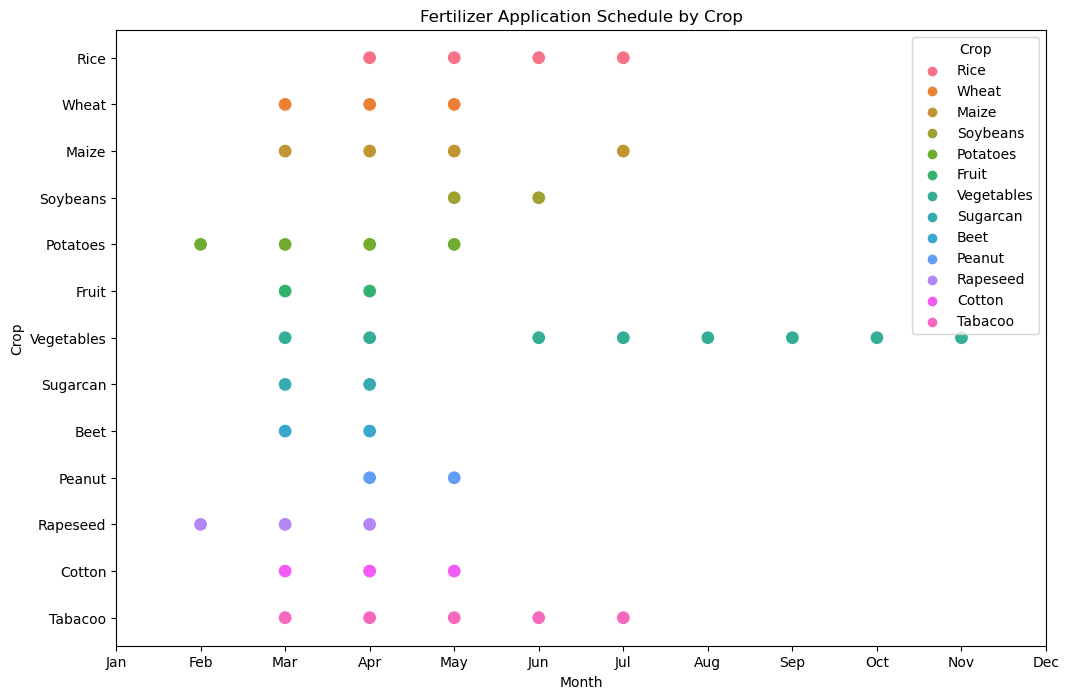

In [6]:
def plot_fertilizer_application(fertilized_months):
    
    # Convert the dictionary into a DataFrame suitable for plotting
    data = []
    for crop, months in fertilized_months.items():
        for month in months:
            data.append({'Crop': crop, 'Month': month})

    df = pd.DataFrame(data)

    # Define the order for the months
    months_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    df['Month'] = pd.Categorical(df['Month'], categories=months_order, ordered=True)

    # Create the plot
    plt.figure(figsize=(12, 8))
    sns.scatterplot(x='Month', y='Crop', hue='Crop', data=df, s=100)

    # Set plot title and labels
    plt.title('Fertilizer Application Schedule by Crop')
    plt.xlabel('Month')
    plt.ylabel('Crop')

    # Adjust the x-axis to explicitly include all months
    plt.xticks(ticks=range(len(months_order)), labels=months_order)

    # Show the plot
    plt.show()


plot_fertilizer_application(Fertilized_Months)

In [7]:
def create_crop_nitrogen_schedule(crop_name, total_n_requirement, application_months):

    # Initialize a dictionary with all months set to zero
    n_schedule = {month: 0 for month in ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']}

    # Calculate the monthly nitrogen requirement
    monthly_n_requirement = total_n_requirement / len(application_months) if application_months else 0

    # Update the nitrogen schedule for the application months
    for month in application_months:
        n_schedule[month] = monthly_n_requirement

    return {crop_name: n_schedule}


crop_name = "Sugarcane"
total_n_requirement = 472
application_months = ['Mar', 'Apr', ]  
# nitrogen_schedule = create_crop_nitrogen_schedule(crop_name, total_n_requirement, application_months)


In [8]:
# NOTE: Only the crops available in the GFSAD1000 are detailed!
# Wheat, Rice, Maize, Soybeans, Cotton, Surgarcane, {Barley, Cassava, Orchards not avaiable in Chineses Data}

# UNIT: kg/hectare
Monthly_N_Requirement = {'Rice': {'Jan': 0, 'Feb': 0, 'Mar': 0, 'Apr': 50.0, 'May': 50.0, 'Jun': 50.0, 'Jul': 50.0, 'Aug': 0, 'Sep': 0, 'Oct': 0, 'Nov': 0, 'Dec': 0},\
                        'Wheat': {'Jan': 0, 'Feb': 0, 'Mar': 73.0, 'Apr': 73.0, 'May': 73.0, 'Jun': 0, 'Jul': 0, 'Aug': 0, 'Sep': 0, 'Oct': 0, 'Nov': 0, 'Dec': 0}, \
                       'Maize': {'Jan': 0, 'Feb': 0, 'Mar': 50.75, 'Apr': 50.75, 'May': 50.75, 'Jun': 0, 'Jul': 50.75, 'Aug': 0, 'Sep': 0, 'Oct': 0, 'Nov': 0, 'Dec': 0}, \
                        'Soybeans': {'Jan': 0, 'Feb': 0, 'Mar': 0, 'Apr': 0, 'May': 0, 'Jun': 27.5, 'Jul': 27.5, 'Aug': 0, 'Sep': 0, 'Oct': 0, 'Nov': 0, 'Dec': 0}, \
                        'Cotton': {'Jan': 0, 'Feb': 0, 'Mar': 113.66666666666667, 'Apr': 113.66666666666667, 'May': 113.66666666666667, 'Jun': 0, 'Jul': 0, 'Aug': 0, 'Sep': 0, 'Oct': 0, 'Nov': 0, 'Dec': 0}, \
                        'Sugarcane': {'Jan': 0, 'Feb': 0, 'Mar': 236.0, 'Apr': 236.0, 'May': 0, 'Jun': 0, 'Jul': 0, 'Aug': 0, 'Sep': 0, 'Oct': 0, 'Nov': 0, 'Dec': 0}}

## Corrected Nitrogen Requirement of Each Crop Each Month

In [9]:
# The Corrected Requirement = Origianl Requirement * Corrected Factor X

def correct_nitrogen_requirements(crop_requirements, correction_factor):

    corrected_requirements = {}

    # Iterate over each crop in the dictionary
    for crop, monthly_requirements in crop_requirements.items():
        corrected_monthly = {}
        
        # Iterate over each month for the current crop
        for month, requirement in monthly_requirements.items():
            # Apply the correction factor
            corrected_monthly[month] = requirement * correction_factor

        corrected_requirements[crop] = corrected_monthly

    return corrected_requirements


correction_factor = X_Correction_Factor('2017')

Corrected_Monthly_N_Requirement_2017 = correct_nitrogen_requirements(Monthly_N_Requirement, correction_factor)
Corrected_Monthly_N_Requirement_2018 = correct_nitrogen_requirements(Monthly_N_Requirement, X_Correction_Factor('2018'))
Corrected_Monthly_N_Requirement_2019 = correct_nitrogen_requirements(Monthly_N_Requirement, X_Correction_Factor('2019'))

Corrected_Monthly_N_Requirement = {}
Corrected_Monthly_N_Requirement['2017'] = Corrected_Monthly_N_Requirement_2017
Corrected_Monthly_N_Requirement['2018'] = Corrected_Monthly_N_Requirement_2018
Corrected_Monthly_N_Requirement['2019'] = Corrected_Monthly_N_Requirement_2019

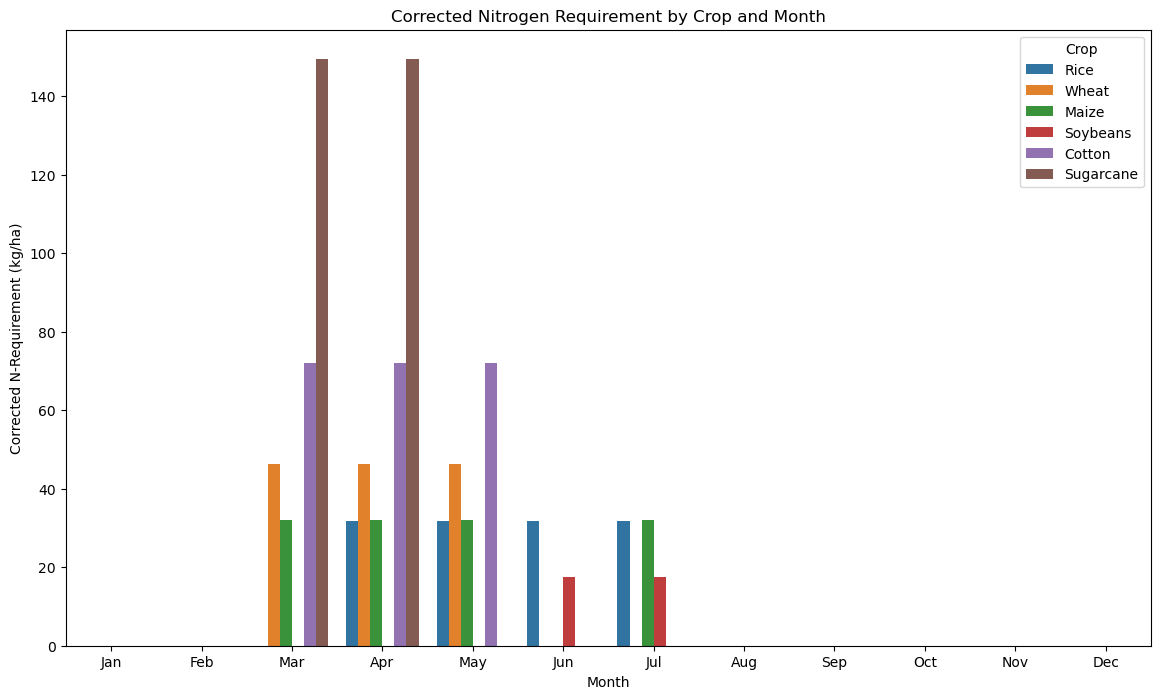

In [10]:
def plot_corrected_n_requirements_bar(corrected_monthly_n_requirement):
    """
    Plots the corrected nitrogen requirement for each month for various crops as a side-by-side bar plot.

    Parameters:
    corrected_monthly_n_requirement (dict): Dictionary with crop names as keys and 
                                             sub-dictionaries of months and N-requirements as values.
    """
    # Convert the dictionary into a DataFrame suitable for plotting
    data = []
    for crop, months_req in corrected_monthly_n_requirement.items():
        for month, requirement in months_req.items():
            data.append({'Crop': crop, 'Month': month, 'N-Requirement': requirement})

    df = pd.DataFrame(data)

    # Define the order for the months
    months_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    df['Month'] = pd.Categorical(df['Month'], categories=months_order, ordered=True)

    # Create the plot
    plt.figure(figsize=(14, 8))
    sns.barplot(x='Month', y='N-Requirement', hue='Crop', data=df)

    # Set plot title and labels
    plt.title('Corrected Nitrogen Requirement by Crop and Month')
    plt.xlabel('Month')
    plt.ylabel('Corrected N-Requirement (kg/ha)')

    # Show the plot
    plt.show()


plot_corrected_n_requirements_bar(Corrected_Monthly_N_Requirement_2017)


## Corrected Nitrogen Requirement of Each Grid Each Month

#### Decide types of crops planned in each grid of GFSAD1000

In [18]:
# Open GFSAD Data with China.shape

def mask_gfsad_with_shapefile(gfsad_path, shapefile_path):
    # Load the GFSAD data
    gfsad_data = rioxarray.open_rasterio(gfsad_path)

    # Load the shapefile
    china_shape = gpd.read_file(shapefile_path)

    # Set the CRS for the shapefile to EPSG:4326 if it is not set
    if china_shape.crs is None:
        china_shape.set_crs(epsg=4326, inplace=True)

    # Transform the shapefile CRS to match the GFSAD data CRS if they are different
    if gfsad_data.rio.crs != china_shape.crs:
        china_shape = china_shape.to_crs(gfsad_data.rio.crs)

    # Clip the GFSAD data using the shapefile
    gfsad_clipped = gfsad_data.rio.clip(china_shape.geometry.apply(mapping), china_shape.crs, drop=True)

    return gfsad_clipped

gfsad_path = '/global/scratch/users/liuwenjin021011/data/GFSAD1000/GFSAD1KCD.2010.001.2016348142525.tif'
shapefile_path = '/global/home/users/liuwenjin021011/logs/fall_2023/China-Doundary-Shape.shp'

# GFSAD_df = mask_gfsad_with_shapefile(gfsad_path, shapefile_path)[0] # this is only 1 band


In [19]:
# decide types of crop planned in each grid based on layer number: https://lpdaac.usgs.gov/products/gfsad1kcdv001

GFSAD_Crop_Dict = {1: ['Wheat', 'Rice'], 
                   2: ['Wheat', 'Rice', 'Barley', 'Soybeans'], \
                   3: ['Wheat', 'Rice', 'Cotton', 'Orchards'],\
                   4: ['Wheat', 'Rice', 'Soybeans', 'Surgarcane', 'Corn', 'Cassava'],\
                   5: ['Wheat', 'Barley'],\
                   6: ['Corn', 'Soybeans'],\
                   7: ['Wheat', 'Corn', 'Rice', 'Barley', 'Soybeans'],\
                   8: ['Wheat', 'Maize', 'Rice', 'Barley', 'Soybeans']
                  }

# GFSAD_df[i][j] == layer_num is True, then GFSAD_df[i][j] has the corresponding planned crops
def map_gfsad_to_crops(gfsad_df, crop_dict):
    # Initialize an empty DataFrame to store the results
    df = pd.DataFrame(columns=['x', 'y', 'planned_crops'])

    # Iterate through each key-value pair in the GFSAD_Crop_Dict
    for value, crops in crop_dict.items():
        # Find the mask where GFSAD_df equals the current value
        mask = gfsad_df == value

        # Convert the mask to DataFrame
        masked_df = mask.to_dataframe(name='mask')

        # Filter out where mask is True
        filtered_df = masked_df[masked_df['mask']]

        # Create a column for planned crops
        filtered_df['planned_crops'] = [crops for _ in range(len(filtered_df))]

        # Append the result to the main DataFrame
        df = pd.concat([df, filtered_df.reset_index()[['x', 'y', 'planned_crops']]], ignore_index=True)

    return df

# GFSAD_df = map_gfsad_to_crops(GFSAD_df, GFSAD_Crop_Dict)

#### Regrid GFSAD Grid to Match that of CHIRPS_SMAP

In [20]:
# Over Sample GFSAD_df to Match the grid of CHIRPS_SMAP, and perserve the content of 'planned crops'
# E.g.: if GFSAD_df[i][j] = ['A'], GFSAD_df[i+1][j] = ['B'], GFSAD_df[i][j+ 1] = ['C'], GFSAD_df[i+1][j+1] = ['A'],
# and after regriding, [i][j], [i+1][j], [i][j+1], [i+1][j+1] match to a new grid, 
# then the 'planned_crops' for the new grid should be ['A', 'B', 'C']

def get_grid_resolution(df, lat_col='lat', lon_col='lon'):
    # Calculate differences in latitudes and longitudes
    lat_diff = np.diff(sorted(df[lat_col].unique()))
    lon_diff = np.diff(sorted(df[lon_col].unique()))

    # Average resolution
    lat_res = np.mean(lat_diff)
    lon_res = np.mean(lon_diff)

    return lat_res, lon_res

# chirps_smap_res = get_grid_resolution(CHIRPS_SMAP_df)

# GFSAD_df.rename(columns={'y': 'lat', 'x': 'lon'}, inplace=True)
# gfsad_res = get_grid_resolution(GFSAD_df)

# print("CHIRPS_SMAP Resolution:", chirps_smap_res)
# print("GFSAD Resolution:", gfsad_res)

In [21]:
import tqdm
def regrid_gfsad_to_match_chirps_smap(GFSAD_gdf, CHIRPS_SMAP_df):
    # Define the grid size for CHIRPS_SMAP
    delta_lon, delta_lat = 0.08829211718930399, 0.09336100444534785

    # Convert CHIRPS_SMAP_df to GeoDataFrame with progress tracking
    geometries = [box(lon - delta_lon/2, lat - delta_lat/2, lon + delta_lon/2, lat + delta_lat/2) 
                  for lon, lat in zip(CHIRPS_SMAP_df['lon'], CHIRPS_SMAP_df['lat'])]
    CHIRPS_SMAP_gdf = gpd.GeoDataFrame(CHIRPS_SMAP_df, geometry=geometries, crs="EPSG:4326")
    
    # Perform spatial join with progress tracking
    tqdm.tqdm.pandas(desc="Spatial Join Progress")
    joined_gdf = gpd.sjoin(CHIRPS_SMAP_gdf, GFSAD_gdf, how='left', op='intersects')

    # Ensure all elements in 'planned_crops' are iterables (replace NaNs with empty lists)
    joined_gdf['planned_crops'] = joined_gdf['planned_crops'].apply(lambda x: x if isinstance(x, list) else [])

    # Group by CHIRPS_SMAP grid and aggregate 'planned_crops'
    tqdm.tqdm.pandas(desc="Aggregating Progress")
    regridded_gdf = joined_gdf.groupby(['lon_left', 'lat_left']).progress_apply(lambda x: list(set.union(*map(set, x['planned_crops'])))).reset_index()

    # Rename columns
    regridded_gdf.rename(columns={'lon_left': 'lon', 'lat_left': 'lat'}, inplace=True)

    return regridded_gdf

def regrid_in_chunks(GFSAD_gdf, CHIRPS_SMAP_df, chunk_size):
    
    # Initialize an empty DataFrame for the regridded data
    regridded_df = pd.DataFrame(columns=['lon', 'lat', 'planned_crops'])

    # Split the CHIRPS_SMAP_df into chunks
    num_chunks = len(CHIRPS_SMAP_df) // chunk_size + 1
    for i in range(num_chunks):
        print(f"Processing chunk {i+1}/{num_chunks}...")
        sub_df = CHIRPS_SMAP_df.iloc[i * chunk_size: (i+1) * chunk_size]

        # Perform spatial join and aggregation for each chunk
        chunk_regridded = regrid_gfsad_to_match_chirps_smap(GFSAD_gdf, sub_df)
        chunk_regridded.to_csv(f'/global/scratch/users/liuwenjin021011/data/GFSAD1000/Regridded_GFSAD_Chunk{i}_Year_2017_With_Status.csv', index = False, header = True)
        # Append the results to the main DataFrame
        regridded_df = pd.concat([regridded_df, chunk_regridded])
        
    
    return regridded_df


#### Join Re-Gridded GFSAD data to CHIRPS-SMAP data

merged_df.to_csv('/global/scratch/users/liuwenjin021011/data/FactorA_CHIRPS_SMAP_GFSAD_Year_2019_With_Status.csv', index= False, header = True)


#### Find corrected monthly N requirement each grid 


In [22]:
# S_CropType --> Planned Area of each major croptype --- Unit: 1000 hectares
# Modify S_CropType to match the keys/categories of Corrected_Monthly_N_Requirement Dict

def map_S_crop_types(S_CropType_Dict, new_crop_keys):

    crop_mapping = {
        'Rice': 'Rice',
        'Wheat': 'Wheat',
        'Corn': 'Maize',
        'Beans': 'Soybeans',  
        'Cotton': 'Cotton',
        'Tubers': 'Sugarcane', 
        'Fiber Crops': 'Sugarcane', 
        'Sugar Crops': 'Sugarcane'
    }

    # Initialize new dictionary with new keys and zero values
    new_dict = {key: 0 for key in new_crop_keys}

    # Iterate and sum the areas for each new crop key
    for old_key, value in S_CropType_Dict.items():
        new_key = crop_mapping.get(old_key)
        if new_key and new_key in new_dict:
            new_dict[new_key] += value

    return new_dict



# Map the crop types
# Mapped_S_CropType_Dict_2017 = map_S_crop_types(S_CropType_Dict['2017'], Corrected_Monthly_N_Requirement['2017'])
# Mapped_S_CropType_Dict_2018 = map_S_crop_types(S_CropType_Dict['2018'], Corrected_Monthly_N_Requirement['2018'])
# Mapped_S_CropType_Dict_2019 = map_S_crop_types(S_CropType_Dict['2019'], Corrected_Monthly_N_Requirement['2019'])

# Mapped_S_CropType_Dict = {}
# Mapped_S_CropType_Dict['2017'] = Mapped_S_CropType_Dict_2017
# Mapped_S_CropType_Dict['2018'] = Mapped_S_CropType_Dict_2018
# Mapped_S_CropType_Dict['2019'] = Mapped_S_CropType_Dict_2019

In [23]:
crop_mapping = {
    'Rice': 'Rice',
    'Wheat': 'Wheat',
    'Barley': 'Wheat',
    'Corn': 'Maize',
    'Maize': 'Maize',
    'Soybeans': 'Soybeans',
    'Cotton': 'Cotton',
    'Surgarcane': 'Sugarcane',
    'Orchards': 'Sugarcane'
}


In [24]:

Monthly_N_Requirement = {
    'Rice': {1: 0, 2: 0, 3: 0, 4: 50.0, 5: 50.0, 6: 50.0, 7: 50.0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0},
    'Wheat': {1: 0, 2: 0, 3: 73.0, 4: 73.0, 5: 73.0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0},
    'Maize': {1: 0, 2: 0, 3: 50.75, 4: 50.75, 5: 50.75, 6: 0, 7: 50.75, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0},
    'Soybeans': {1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 27.5, 7: 27.5, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0},
    'Cotton': {1: 0, 2: 0, 3: 113.67, 4: 113.67, 5: 113.67, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0},
    'Sugarcane': {1: 0, 2: 0, 3: 236.0, 4: 236.0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0}
}

from tqdm import tqdm

def calculate_corrected_n_requirement(df, mapped_area_dict, n_requirement_dict, crop_mapping, progress_label):
    
    N_Requirements = []
    
    # Iterate through each row in the dataframe with tqdm progress bar
    for index in tqdm(df.index, desc=progress_label, unit="row"):
        row = df.loc[index]
        all_crops = row['planned crops']
        if len(all_crops) == 0:
            N_Requirements += [0]
            continue
        # print('all crops:', all_crops)

        # Find Unique Crops to avoid doubt counting
        unique_crops = []
        for crop in all_crops:
            mapped_crop = crop_mapping.get(crop, crop)
            if mapped_crop not in unique_crops:
                unique_crops += [mapped_crop]       
        # print('unique crops after mapping:', unique_crops)
    
        
        # Do not include the Crop is the Crop is not planned in the corresponding Month/ N_requirement for that month = 0
        # print(n_requirement_dict)
        unique_planned_crops = []
        month = datetime.strptime(row['time'], "%Y-%m-%d").month
        for crop in unique_crops:
            mapped_crop = crop_mapping.get(crop, crop)
            fertilizing_months = n_requirement_dict.get(mapped_crop)
            if fertilizing_months:
                if fertilizing_months.get(month) != 0:
                    unique_planned_crops += [mapped_crop]
        # print('unique crops fertilized in month', month, ' are ', unique_planned_crops)   
        
        # Calculate total planned area for all crops in this grid
        planned_area = {}
        for mapped_crop in unique_planned_crops:
            planned_area[mapped_crop] = mapped_area_dict.get(mapped_crop, 0)
        total_area = sum(planned_area.values())
        
        # Calculate monthly N requirement
        total_pro = 0
        if total_area > 0:
            total_N = 0
            for mapped_crop in unique_planned_crops:
                crop_area = mapped_area_dict.get(mapped_crop, 0)
                crop_proportion = crop_area / total_area
                total_pro += crop_proportion
        
                crop_monthly_n = Monthly_N_Requirement.get(mapped_crop)
                monthly_n = crop_monthly_n.get(month)
                # print(mapped_crop, crop_monthly_n, monthly_n)
                
                total_N += monthly_n * crop_proportion
            
            N_Requirements += [total_N]
            assert round(total_pro) == 1
        else:
            N_Requirements += [total_N]
            
    df['F [N Requirement]'] = N_Requirements

    return df


# mapped_area_dict = Mapped_S_CropType_Dict['2017']
# n_requirement_dict = Corrected_Monthly_N_Requirement['2017']
# test_df = calculate_corrected_n_requirement(CHIRPS_SMAP_GFSAD_df[99:100], mapped_area_dict, n_requirement_dict, crop_mapping, '1')

#### Convert Monthly N Requirement for each grid to Daily

## F - Corrected N Requirement Combined

In [25]:
Lower_lat_Lower_lon = []
Lower_lat_Upper_lon = []
Upper_lat_Lower_lon = []
Upper_lat_Upper_lon = []
F_dir = '/global/scratch/users/liuwenjin021011/data/ThesisFactorA/'
for file in os.listdir(F_dir):
    if 'Year2019_Lower_lat_Lower_lon_Chunk' in file:
        Lower_lat_Lower_lon += [F_dir + file]
        
    if 'Year2019_Lower_lat_Upper_lon_Chunk' in file:
        Lower_lat_Upper_lon += [F_dir + file]
        
    if 'Year2019_Upper_lat_Lower_lon_Chunk' in file:
        Upper_lat_Lower_lon += [F_dir + file]
    
    if 'Year2019_Upper_lat_Upper_lon_Chunk' in file:
        Upper_lat_Upper_lon += [F_dir + file]
        
Lower_lat_Lower_lon.sort()
Lower_lat_Upper_lon.sort()
Upper_lat_Lower_lon.sort()
Upper_lat_Upper_lon.sort()

In [26]:
def merge_file(file_list, save_name):
    all_df = pd.DataFrame()
    for file in file_list:
        chunk_df = pd.read_csv(file)
        all_df = pd.concat([all_df, chunk_df])
        
    # all_df = all_df.drop(columns = ['Unnamed: 0'])
    all_df = all_df.drop_duplicates()
    all_df.to_csv(f'/global/scratch/users/liuwenjin021011/data/ThesisFactorA/Year2019_{save_name}.csv')
    
merge_file(Lower_lat_Lower_lon, 'Lower_lat_Lower_lon')
merge_file(Lower_lat_Upper_lon, 'Lower_lat_Upper_lon')
merge_file(Upper_lat_Lower_lon, 'Upper_lat_Lower_lon')
merge_file(Upper_lat_Upper_lon, 'Upper_lat_Upper_lon')

In [27]:
ll_df = pd.read_csv('/global/scratch/users/liuwenjin021011/data/ThesisFactorA/Year2019_Lower_lat_Lower_lon.csv')

In [28]:
lu_df = pd.read_csv('/global/scratch/users/liuwenjin021011/data/ThesisFactorA/Year2019_Lower_lat_Upper_lon.csv')

In [29]:
ul_df = pd.read_csv('/global/scratch/users/liuwenjin021011/data/ThesisFactorA/Year2019_Upper_lat_Lower_lon.csv')

In [30]:
uu_df = pd.read_csv('/global/scratch/users/liuwenjin021011/data/ThesisFactorA/Year2019_Upper_lat_Upper_lon.csv')

In [31]:
df = pd.concat([ll_df, lu_df, ul_df, uu_df])

In [32]:
df

,Unnamed: 0,lat,lon,interpolated_precip,temp,time,status,planned crops,F [N Requirement]
0,0,20.513201,100.783195,0.0,289.77620,2019-01-01,dry,"""[]""",0
1,9,20.513201,86.779045,0.0,292.57483,2019-01-01,dry,"""[]""",0
2,17,20.513201,86.872406,0.0,292.58292,2019-01-01,dry,"""[]""",0
3,25,20.513201,86.965767,0.0,292.58942,2019-01-01,dry,"""[]""",0
4,32,20.513201,87.059128,0.0,292.59427,2019-01-01,dry,"""[]""",0
...,...,...,...,...,...,...,...,...,...
11016091,3828560,44.945248,127.671165,0.0,268.96545,2019-12-31,dry,"""[\""Barley\"", \""Orchards\"", \""Wheat\"", \""Cotto...",0
11016092,3828568,44.945248,127.764526,0.0,268.91513,2019-12-31,dry,"""[\""Barley\"", \""Wheat\"", \""Rice\"", \""Maize\"", ...",0
11016093,3828576,44.945248,127.857887,0.0,268.89468,2019-12-31,dry,"""[\""Barley\"", \""Wheat\"", \""Rice\"", \""Maize\"", ...",0
11016094,3828584,44.945248,127.951248,0.0,268.90417,2019-12-31,dry,"""[\""Barley\"", \""Wheat\"", \""Cassava\"", \""Surgar...",0


In [2]:
ll_df = pd.read_csv('/global/scratch/users/liuwenjin021011/data/ThesisFactorA/Year2019_Lower_lat_Lower_lon.csv')
lu_df = pd.read_csv('/global/scratch/users/liuwenjin021011/data/ThesisFactorA/Year2019_Lower_lat_Upper_lon.csv')
ul_df = pd.read_csv('/global/scratch/users/liuwenjin021011/data/ThesisFactorA/Year2019_Upper_lat_Lower_lon.csv')
uu_df = pd.read_csv('/global/scratch/users/liuwenjin021011/data/ThesisFactorA/Year2019_Upper_lat_Upper_lon.csv')
df = pd.concat([ll_df, lu_df, ul_df, uu_df])
df

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,lat,lon,interpolated_precip,temp,time,status,planned crops,F [N Requirement]
0,0.0,0.0,0.0,22.559193,84.258301,0.0,290.96832,2018-01-01,dry,[],0.0
1,1.0,1.0,9.0,22.559193,84.164940,0.0,290.94904,2018-01-01,dry,[],0.0
2,2.0,2.0,18.0,22.559193,84.071579,0.0,290.93433,2018-01-01,dry,[],0.0
3,3.0,3.0,27.0,22.559193,83.978218,0.0,290.92330,2018-01-01,dry,[],0.0
4,4.0,4.0,36.0,22.559193,83.884857,0.0,290.91130,2018-01-01,dry,[],0.0
...,...,...,...,...,...,...,...,...,...,...,...
12234997,NaN,NaN,4718967.0,34.010128,134.859955,0.0,279.44490,2018-12-31,wet,[],0.0
12234998,NaN,NaN,4718979.0,34.010128,134.206436,0.0,276.57138,2018-12-31,wet,[],0.0
12234999,NaN,NaN,4718991.0,34.010128,134.113068,0.0,276.43558,2018-12-31,wet,[],0.0
12235000,NaN,NaN,4719003.0,34.010128,134.019714,0.0,276.42850,2018-12-31,wet,[],0.0


In [33]:
# df = pd.concat([ll_df, lu_df, ul_df, uu_df])
set(df['time'])

{'2019-01-01',
 '2019-01-02',
 '2019-01-03',
 '2019-01-04',
 '2019-01-05',
 '2019-01-06',
 '2019-01-07',
 '2019-01-08',
 '2019-01-09',
 '2019-01-10',
 '2019-01-11',
 '2019-01-12',
 '2019-01-13',
 '2019-01-14',
 '2019-01-15',
 '2019-01-16',
 '2019-01-17',
 '2019-01-18',
 '2019-01-19',
 '2019-01-20',
 '2019-01-21',
 '2019-01-22',
 '2019-01-23',
 '2019-01-24',
 '2019-01-25',
 '2019-01-26',
 '2019-01-27',
 '2019-01-28',
 '2019-01-29',
 '2019-01-30',
 '2019-01-31',
 '2019-02-01',
 '2019-02-02',
 '2019-02-03',
 '2019-02-04',
 '2019-02-05',
 '2019-02-06',
 '2019-02-07',
 '2019-02-08',
 '2019-02-09',
 '2019-02-10',
 '2019-02-11',
 '2019-02-12',
 '2019-02-13',
 '2019-02-14',
 '2019-02-15',
 '2019-02-16',
 '2019-02-17',
 '2019-02-18',
 '2019-02-19',
 '2019-02-20',
 '2019-02-21',
 '2019-02-22',
 '2019-02-23',
 '2019-02-24',
 '2019-02-25',
 '2019-02-26',
 '2019-02-27',
 '2019-02-28',
 '2019-03-01',
 '2019-03-02',
 '2019-03-03',
 '2019-03-04',
 '2019-03-05',
 '2019-03-06',
 '2019-03-07',
 '2019-03-

In [4]:
df

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,lat,lon,interpolated_precip,temp,time,status,planned crops,F [N Requirement]
0,0.0,0.0,0.0,22.559193,84.258301,0.0,290.96832,2018-01-01,dry,[],0.0
1,1.0,1.0,9.0,22.559193,84.164940,0.0,290.94904,2018-01-01,dry,[],0.0
2,2.0,2.0,18.0,22.559193,84.071579,0.0,290.93433,2018-01-01,dry,[],0.0
3,3.0,3.0,27.0,22.559193,83.978218,0.0,290.92330,2018-01-01,dry,[],0.0
4,4.0,4.0,36.0,22.559193,83.884857,0.0,290.91130,2018-01-01,dry,[],0.0
...,...,...,...,...,...,...,...,...,...,...,...
12234997,NaN,NaN,4718967.0,34.010128,134.859955,0.0,279.44490,2018-12-31,wet,[],0.0
12234998,NaN,NaN,4718979.0,34.010128,134.206436,0.0,276.57138,2018-12-31,wet,[],0.0
12234999,NaN,NaN,4718991.0,34.010128,134.113068,0.0,276.43558,2018-12-31,wet,[],0.0
12235000,NaN,NaN,4719003.0,34.010128,134.019714,0.0,276.42850,2018-12-31,wet,[],0.0


In [34]:
df.to_csv('/global/scratch/users/liuwenjin021011/data/ThesisFactorA/Year2019_F.csv', header = True, index = False)